# Обучение 2 слойной нейронной сети

## Модель нейрона

Функция преобразования нейрона:
$$
y = \nu(\mathbf{x}, \mathbf{w}) = 
\sigma\Bigl(w_0+\sum_{i=1}^n w_ix_i\Bigr)
$$

где 
$$
\sigma(s) = \frac{1-e^{-x}}{1+e^{-x}}
$$

Частные производные по $w_0$ и $w_i$:
$$
\frac{\partial\nu}{\partial w_0}=\sigma^\prime(s)
$$

$$
\frac{\partial\nu}{\partial w_i}=\sigma^\prime(s)x_i
$$

где 
$$
s = w_0+\sum_{i=1}^n w_ix_i
$$

$$
\sigma^\prime(x) = \frac{2e^x}{(e^x + 1)^2}
$$

На практике переходят от вектора $(x_1,\dots,x_n)$ к расширенному вектору $(1,x_1,\dots,x_n)$, и соответственно, к вектору весов $(w_0,w_1,\dots,w_n)$.

В результате формулы приобретают более простой вид:

$$
\nu(\mathbf{x})=\sigma(\mathbf{w}\cdot\mathbf{x})
$$

$$
\text{grad}\,\nu(\mathbf{x},\mathbf{w})=\sigma^\prime(s) \mathbf{x}
$$

In [1]:
from __future__ import print_function, unicode_literals, division

In [2]:
import numpy as np

In [3]:
class NeuronModel(object):
    #
    def __init__(self, param):
        self.param = param
    #
    def evaluate(self, x):
        s = np.inner(self.param, x)
        self.s = s
        e = np.exp(-s)
        v = (1-e)/(1+e)
        return v
    #
    def gradient(self, x):
        s = np.inner(self.param, x)
        self.s = s
        e = np.exp(-s)
        v = 2*e/(1+e)**2
        return v * x
    #
    def gradient_x(self, x):
        s = np.inner(self.param, x)
        self.s = s
        e = np.exp(-s)
        v = 2*e/(1+e)**2
        return v * self.param[1:]
    

In [4]:
neuro = NeuronModel(np.array([1.0,1.0,1.0]))
x = np.array([1.0,1.0,1.0])
print(neuro.evaluate(x))
print(neuro.gradient(x))
print(neuro.gradient_x(x))

0.905148253645
[ 0.09035332  0.09035332  0.09035332]
[ 0.09035332  0.09035332]


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
X1 = np.linspace(-5, 5, 100)
X2 = np.linspace(-5, 5, 100)
XX1, XX2 = np.meshgrid(X1, X2)
XX = np.c_[np.ones(10000),XX1.ravel(),XX2.ravel()]

In [7]:
Y = neuro.evaluate(XX)
YY = Y.reshape(XX1.shape)

In [8]:
from mpl_toolkits.mplot3d import axes3d

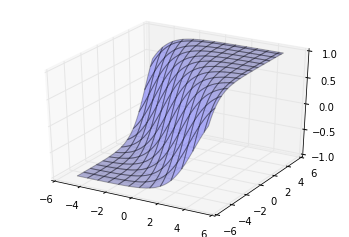

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(XX1, XX2, YY, rstride=8, cstride=8, alpha=0.3)

In [10]:
class NeuralNet(object):
    #
    def __init__(self, n_inputs, n_hidden):
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        
        self.hidden = []
        for j in range(n_hidden):
            param = np.random.random((n_inputs+1,))
            neuron = NeuronModel(param)
            self.hidden.append(neuron)
            
        param = np.random.random((n_hidden+1,))
        self.head = NeuronModel(param)
    #
    def evaluate(self, inputs):
        
        hidden_values = np.array([neuron.evaluate(inputs) for neuron in self.hidden])
        
        u = np.empty((self.n_hidden+1,), dtype=np.double)
        u[0] = 1
        u[1:] = hidden_values[:]
        
        y = self.head.evaluate(u)
        return y

Функция преобразования нейронной сети:

$$
y = \sigma(\mathbf{w}\cdot\mathbf{u}),
$$
где $\mathbf{u}=(1,u_1,\dots,u_m)$, $\mathbf{w}=(w_0,w_1,\dots,w_m)$.

$$
u_j = \sigma(\mathbf{w_j}\cdot\mathbf{x}),\quad j=1,\dots,m,
$$
где $\mathbf{w_j}=(w_{j0},w_{j1},\dots,w_{jn})$, $\mathbf{x}=(1,x_1,\dots,x_n)$.

$$
\mathcal{Q}(W)=\frac 1 N \sum_{k=1}^N (F(\mathbf{x}_k,W)-y_k)^2
$$

$$
2(F(\mathbf{x}_k,W)-y_k)\text{grad}\,F(\mathbf{x}_k,W)
$$

In [23]:
class SGD4NN(object):
    #
    def __init__(self, nn, h0=1.0, max_epoch=1000, eps=1.0e-6):
        self.nn = nn
        self.max_epoch = max_epoch
        self.h0 = h0
        self.eps = eps
    #
    def fit(self, X, Y):
        #
        self.K = 0
        while self.K < self.max_epoch:
            self.h = self.h0 / (1 + self.K)
            self.prev_param = self.nn.head.param.copy()
            self.prev_params = [n.param.copy() for n in self.nn.hidden]
            self.fit_epoch(X, Y)
            if self.stop_condition():
                break
            
            self.K += 1
            
    def fit_epoch(self, X, Y):
        N = len(X)
        indexes = np.random.randint(0, N, (N,))
        for k in indexes:
            Xk = X[k]
            yk = Y[k]
            # адаптируем параметры НС для заданных входов Xk и выхода yk
            self.fit_param(Xk, yk, k)
    #        
    def fit_param(self, Xk, yk, k):
        err = self.nn.evaluate(Xk) - yk
        grad = self.nn.head.gradient(Xk)
        self.nn.head.param -= 2 * self.h * err * grad
        
        grad_u = self.nn.head.gradient_x(Xk)
        for j in range(self.nn.n_hidden):
            neuron_j = self.nn.hidden[j]
            neuron_j.param -= 2* self.h * err * grad_u[j] * neuron_j.gradient(Xk)
    #
    def stop_condition(self):
        dw = np.max(np.abs(self.nn.head.param - self.prev_param))
        if dw > self.eps:
            return False
        
        for i in range(self.nn.n_hidden):
            dw = np.max(np.abs(self.nn.hidden[i].param - self.prev_params[i]))
            if dw > self.eps:
                return False
                        
        return True
    
        

Функция преобразования в обобщенном виде имеет вид:

$$y = f(U,W)$$

$$
u_j = f_j(X,W_j),\quad j=1,\dots,m
$$

$\displaystyle G=\text{grad}\,f$

$\displaystyle G_j = \text{grad}\,f_j$

$\displaystyle \text{grad}\,F = \text{grad}\,f \big| \dfrac{\partial f}{\partial u_1}\text{grad}\,f_1\big|\dots \big|\dfrac{\partial f}{\partial u_m}\text{grad}\,f_m$

In [19]:
Xs = [
    np.array([1., 0., 0.]),
    np.array([1., 0., 1.]),
    np.array([1., 1., 0.]),
    np.array([1., 1., 1.]),
]
Ys = [0., 1., 1., 0.]

In [67]:
nn = NeuralNet(2, 2)
sgd = SGD4NN(nn, eps=1.0e-8, max_epoch=10000, h0=6.0)

In [68]:
sgd.fit(Xs, Ys)
print("K:", sgd.K)
print(nn.head.param)
for n in nn.hidden:
    print(n.param)

K: 10000
[ 3.81706924  5.24171319  0.973683  ]
[-1.62857658  0.54741299  1.27556447]
[-0.35408958  0.24029787  0.58696419]


In [69]:
Ys1 = [nn.evaluate(x) for X in Xs]
print(Ys, Ys1)

[0.0, 1.0, 1.0, 0.0] [0.9791098289618384, 0.9791098289618384, 0.9791098289618384, 0.9791098289618384]
